In [225]:
"""
Script for merging data from DPS of TEll40

VADAQTELL40:Velo_TELL40_Mij_*_k.luminosity_rates.inst_lumi_bb

The script is called via

python3 merge_data.py
 
"""

import os
from os.path import exists
import sys
from functools import reduce
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.errors import EmptyDataError
import matplotlib.pyplot as plt
import yaml
import seaborn as sns
import colorcet as cc
from scipy.stats import trim_mean
import datetime as dt



def get_data(path, count_type, year):
    """
    Load data from a CSV file, format it, and return a DataFrame.

    Args:
        path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: The formatted DataFrame.
    """
    str_year = year
    _, tail = os.path.split(path)
    root, _ = os.path.splitext(tail)
    df = pd.read_csv(path)
    df["TS"] = pd.to_datetime(df["TS"], format="%d-%m-%Y %H:%M:%S.%f")
    df["TS"] = df["TS"].dt.floor("S")
    df = df.drop(columns=[" DPE"])
    newname = root.replace("output_", "")
    count_type = count_type.replace("../" + str_year + "/input_data/", "")
    count_type = count_type.replace("_inner", "")
    if newname.startswith("M"):
        newname = newname + count_type
    df = df.rename(columns={" VALUE": newname})
    return df


def create_file_list(config_dict, count_type, counter):
    """
    Create a list of DataFrames to merge. Handle B4BB1E, infinity, and empty rows.

    Args:
        config_dict (dict): Configuration dictionary.
        count_type (str): Type of count ("bb" or "bb_inner").
        counter (str): Name of module (e.g. M23_0)

    Returns:
        list: List of DataFrames to merge.
    """
    start_time = config_dict["StartOfData"]
    end_time = config_dict["EndOfData"]
    str_year = config_dict["folder_name"]
    
    file_list = []

    count_type_bb = "../" + str_year + "/input_data/" + count_type
    count_type_eb = "../" + str_year + "/input_data/eb" + count_type[2:]
    count_type_be = "../" + str_year + "/input_data/be" + count_type[2:]
    count_type_ee = "../" + str_year + "/input_data/ee" + count_type[2:]

    path_to_search = [count_type_bb, count_type_be, count_type_eb, count_type_ee]
    for path_to_folder in path_to_search:
        for root_folder, _, files in os.walk(path_to_folder):
            for file in files:
                if file == "output_" + counter + ".csv":
                    try:
                        _, tail = os.path.split(path_to_folder)
                        root, _ = os.path.splitext(tail)
                        full_path = os.path.join(root_folder, file)
                        element = get_data(str(full_path), root, str_year)
                        element = element.loc[element["TS"] >= start_time]
                        element = element.loc[element["TS"] <= end_time]
                        numeric_columns = element.select_dtypes(
                            include=["int64", "float64"]
                        )
                        for col in numeric_columns:
                            element = element.loc[
                                element[col] != 9.9900000000000004e125
                            ]
                            element = element.loc[element[col] != 1.2237598e7]
                            element = element.loc[element[col] != 7.64849875e5]
                            if element.loc[:, col].mean() != 0 and not np.isnan(  # type: ignore
                                element.loc[:, col].mean()
                            ):
                                element = (
                                    element.drop_duplicates("TS")
                                    .set_index("TS")
                                    .resample("3s")
                                    .ffill()
                                    .reset_index()
                                )
                                file_list.append(element)
                                print(
                                    "File successfully formatted and inserted into the list"
                                )
                            else:
                                print("Too many B4BB1E. File will not be processed")
                    except EmptyDataError:
                        print(f"No columns to parse from file {str(file)}")
                        print("File will not be processed")
                    # except FileNotFoundError:
                    #    print(f"still searching for {str(file)}")
    return file_list


def merge_dataset(config_dict, input_file):
    """
    Merge the CSV data of each TELL40 into one DataFrame with a unique timestamp, which will be set as the index.

    Args:
        config_dict (dict): Configuration dictionary.
        input_file (str): Type of input file (e.g., "bb" or "bb_inner").

    Returns:
        pd.DataFrame: Merged DataFrame.
    """

    # define an empty list where to store all the csv counters
    df_list = []
    # get sigma vis data
    df_sigma_vis = pd.read_csv("../" + config_dict["folder_name"] + "/sigma_vis.csv")
    df_sigma_vis.set_index("colName",inplace=True)
    calib_colname = list(df_sigma_vis.index)
    # get list of counters from configuration file
    for counter in config_dict["counters_name"]:
        
        # create a list with the bxtype counters for a module (in counters list you find bb, eb, be ee for a single counter)
        counters_list = create_file_list(config_dict, input_file, counter)
        # if the list is empty (no data for counters were found) skip loop
        if not counters_list:
            continue

        # merge the different type of counters in a unique timestamp
        df_merged_bb = reduce(
            lambda left, right: pd.merge_asof(
                left,
                right,
                on="TS",
                direction="nearest",
                tolerance=pd.Timedelta("3s"),
            ),
            counters_list,
        )
        # define a list with the existing counters
        var_list = [col for col in df_merged_bb.columns if col.startswith("M")]
        
        for el in var_list:
            if input_file == "bb_inner":
                inner_calib_colname = [col for col in calib_colname if col.endswith("inner")]
                inner_calib_colname = [x.replace('_inner', '') for x in inner_calib_colname]
                if el[:-2] not in inner_calib_colname:
                    continue
                col_name = f"{el[:-2]}_inner"
                print(f"Processing {str(col_name)} counters")
                
                # subtract background
                df_merged_bb[col_name] = (
                    df_merged_bb[el[:-2] + "bb"]
                    - df_merged_bb[el[:-2] + "be"]
                    - 16 * df_merged_bb[el[:-2] + "ee"]
                )
                # define error
                new_col_name = f"Delta_{el[:-2]}_inner"
                # function calculated with monte carlo
                df_merged_bb[new_col_name] = 0.000709511 * np.sqrt(
                    0.955167
                    * (
                        df_merged_bb[el[:-2] + "bb"]
                        + df_merged_bb[el[:-2] + "be"]
                        + 16 * df_merged_bb[el[:-2] + "ee"]
                    )
                )
                # define lumi
                lumi_col_name = f"lumi_{col_name}"
                df_merged_bb[lumi_col_name] = (
                    df_merged_bb[col_name]
                    * config_dict["nCollisions"]
                    * config_dict["lhc_frequency"]
                    / df_sigma_vis.loc[col_name]["calibration"]
                )
                # define error lumi
                lumi_err_col_name = f"lumi_err_{col_name}"
                df_merged_bb[lumi_err_col_name] = (
                    np.sqrt(
                        (
                            df_merged_bb[new_col_name]
                            / df_sigma_vis.loc[col_name]["calibration"]
                        )
                        ** 2
                        + (
                            df_merged_bb[col_name]
                            * df_sigma_vis.loc[col_name]["error_calibration"]
                            / (df_sigma_vis.loc[col_name]["calibration"] ** 2)
                        )
                        ** 2
                    )
                    * config_dict["nCollisions"]
                    * config_dict["lhc_frequency"]
                )

                
            else:
                inner_calib_colname = [col for col in calib_colname if col.endswith("outer")]
                inner_calib_colname = [x.replace('_outer', '') for x in inner_calib_colname]
                if el[:-2] not in inner_calib_colname:
                    continue
                col_name = f"{el[:-2]}_outer"
                print(f"Processing {str(col_name)} counters")
                # subtract background
                df_merged_bb[col_name] = (
                    df_merged_bb[el[:-2] + "bb"]
                    - df_merged_bb[el[:-2] + "be"]
                    - df_merged_bb[el[:-2] + "eb"]
                    + df_merged_bb[el[:-2] + "ee"]
                )
                # define error
                new_col_name = f"Delta_{el[:-2]}_outer"
                df_merged_bb[new_col_name] = 0.000709511 * np.sqrt(
                    0.955167
                    * (
                        df_merged_bb[el[:-2] + "bb"]
                        + df_merged_bb[el[:-2] + "be"]
                        + df_merged_bb[el[:-2] + "eb"]
                        + df_merged_bb[el[:-2] + "ee"]
                    )
                )# define lumi
                lumi_col_name = f"lumi_{col_name}"
                df_merged_bb[lumi_col_name] = (
                    df_merged_bb[col_name]
                    * config_dict["nCollisions"]
                    * config_dict["lhc_frequency"]
                    / df_sigma_vis.loc[col_name]["calibration"]
                )
                # define error lumi
                lumi_err_col_name = f"lumi_err_{col_name}"
                df_merged_bb[lumi_err_col_name] = (
                    np.sqrt(
                        (
                            df_merged_bb[new_col_name]
                            / df_sigma_vis.loc[col_name]["calibration"]
                        )
                        ** 2
                        + (
                            df_merged_bb[col_name]
                            * df_sigma_vis.loc[col_name]["error_calibration"]
                            / (df_sigma_vis.loc[col_name]["calibration"] ** 2)
                        )
                        ** 2
                    )
                    * config_dict["nCollisions"]
                    * config_dict["lhc_frequency"]
                )


        # define columns to remove: every type counters
        col_to_remove = [
            col
            for col in df_merged_bb.columns
            if (
                col.endswith("bb")
                or col.endswith("be")
                or col.endswith("eb")
                or col.endswith("ee")
            )
        ]
        # drop the columns defined above
        df_merged_bb.drop(columns=col_to_remove, inplace=True)

        df_list.append(df_merged_bb)

        # df_merged_bb.to_csv("merged_counters/merged_" + counter + ".csv")
    # merge all counters in a single csv
    df_merged_unique = reduce(
        lambda left, right: pd.merge_asof(
            left,
            right,
            on="TS",
            direction="nearest",
            tolerance=pd.Timedelta("3s"),
        ),
        df_list,
    )
    df_merged_unique.set_index("TS", inplace=True)
    return df_merged_unique


def plot_figure(df, year):
    """
    Create a figure to display counters.

    Args:
        df (pd.DataFrame): DataFrame with counters data.
        year (str): Year of vdm (e.g., "2022" or "2023").
    """

    y_lab = "Avg counts"
    _, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 20))

    counters_col = [col for col in df.columns if col.startswith("M")]
    df_counters = df[counters_col]

    num_colors = len(counters_col)

    sns.reset_orig()
    palette = sns.color_palette(cc.glasbey, n_colors=num_colors)

    ax1 = df_counters.plot(
        marker=".",
        markersize=1,
        title="lumi estimate for ",
        xlabel="Time Stamp (H)",
        ylabel=y_lab,
        color=palette,
        ax=axes[0],
    )

    ax1.legend(prop={"size": 1}, ncols=10)

    plt.show()


In [33]:
stream = open("config.yaml", "r", encoding="utf-8")
config_dictionary = yaml.safe_load(stream)
    # set options according to configuration file
display_fig = config_dictionary["displayFig"]
    # input_file = "bb"
folder_name = config_dictionary["folder_name"]

    # if the dataset is not already create, merge all the counters in a csv file
if not exists("../" + folder_name + "/input_data/data_merged.csv"):
    df_merged_bb = merge_dataset(config_dictionary, "bb")
    df_merged_bb_inner = merge_dataset(config_dictionary, "bb_inner")
    df_merged_unique = pd.merge_asof(
            df_merged_bb,
            df_merged_bb_inner,
            left_index=True,
            right_index=True,
            direction="nearest",
            tolerance=pd.Timedelta("3s"),
        )
    mask = (df_merged_unique.index > config_dictionary["StartOfData"]) & (
            df_merged_unique.index <= config_dictionary["EndOfData"]
        )
    df_merged_unique = df_merged_unique.loc[mask]

    df_merged_unique.to_csv("../" + folder_name + "/input_data/data_merged.csv")

File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M00_0_outer counters
Processing M00_0_outer counters
Processing M00_0_outer counters
Processing M00_0_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M00_1_outer counters
Processing M00_1_outer counters
Processing M00_1_outer counters
Processing M00_1_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M01_0_outer counters
Processing M01_0_outer counters
Processing M01_0_out

Processing M11_1_outer counters
Processing M11_1_outer counters
Processing M11_1_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M12_0_outer counters
Processing M12_0_outer counters
Processing M12_0_outer counters
Processing M12_0_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M12_1_outer counters
Processing M12_1_outer counters
Processing M12_1_outer counters
Processing M12_1_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted in

File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M23_1_outer counters
Processing M23_1_outer counters
Processing M23_1_outer counters
Processing M23_1_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M24_0_outer counters
Processing M24_0_outer counters
Processing M24_0_outer counters
Processing M24_0_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M24_1_outer counters
Processing M24_1_outer counters
Processing M24_1_outer counters
Processing M24_1_outer counters
File successfully formatted and inserted into the list
File succes

File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M35_1_outer counters
Processing M35_1_outer counters
Processing M35_1_outer counters
Processing M35_1_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M36_0_outer counters
Processing M36_0_outer counters
Processing M36_0_outer counters
Processing M36_0_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M36_1_outer counters
Processing M36_1_outer counters
Processing M36_1_outer counters
Processing M36_1_outer counters
File successfully formatted and inserted into the list
File succes

File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M48_1_outer counters
Processing M48_1_outer counters
Processing M48_1_outer counters
Processing M48_1_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M49_0_outer counters
Processing M49_0_outer counters
Processing M49_0_outer counters
Processing M49_0_outer counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M49_1_outer counters
Processing M49_1_outer counters
Processing M49_1_outer counters
Processing M49_1_outer counters
File succes

File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M11_1_inner counters
Processing M11_1_inner counters
Processing M11_1_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M12_0_inner counters
Processing M12_0_inner counters
Processing M12_0_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M12_1_inner counters
Processing M12_1_inner counters
Processing M12_1_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M13_0_inner counters
Processing M13_0_inner counters
Processing M13_0_inner counters
File succes

Processing M27_0_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M27_1_inner counters
Processing M27_1_inner counters
Processing M27_1_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M28_0_inner counters
Processing M28_0_inner counters
Processing M28_0_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M28_1_inner counters
Processing M28_1_inner counters
Processing M28_1_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M29_0_inn

File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M44_1_inner counters
Processing M44_1_inner counters
Processing M44_1_inner counters
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
File successfully formatted and inserted into the list
Processing M46_0_inner c

In [36]:
#Fill 9137
selected_columns = df_merged_unique.filter(regex='^lumi_M')
selected_columns

lumi_M00_0_outer  lumi_M00_1_outer  lumi_M01_0_outer  \
TS                                                                          
2023-09-10 08:36:51               NaN               NaN               0.0   
2023-09-10 08:36:54               0.0               0.0               0.0   
2023-09-10 08:36:57               0.0               0.0               0.0   
2023-09-10 08:37:00               0.0               0.0               0.0   
2023-09-10 08:37:03               0.0               0.0               0.0   
...                               ...               ...               ...   
2023-09-27 15:45:06               0.0               0.0               NaN   
2023-09-27 15:45:09               0.0               0.0               NaN   
2023-09-27 15:45:12               0.0               0.0               NaN   
2023-09-27 15:45:15               0.0               0.0               NaN   
2023-09-27 15:45:18               0.0               0.0               NaN   

                     lumi_M01_1_outer  lumi_M02_0_outer  lumi_M02_1_outer  \
TS                                                                          
2023-09-10 08:36:51               0.0               0.0               0.0   
2023-09-10 08:36:54               0.0               0.0               0.0   
2023-09-10 08:36:57               0.0               0.0               0.0   
2023-09-10 08:37:00               0.0               0.0               0.0   
2023-09-10 08:37:03               0.0               0.0               0.0   
...                               ...               ...               ...   
2023-09-27 15:45:06               NaN               0.0               0.0   
2023-09-27 15:45:09               NaN               0.0               0.0   
2023-09-27 15:45:12               NaN               0.0               0.0   
2023-09-27 15:45:15               NaN               0.0               0.0   
2023-09-27 15:45:18               NaN               0.0               0.0   

                     lumi_M03_0_outer  lumi_M03_1_outer  lumi_M04_0_outer  \
TS                                                                          
2023-09-10 08:36:51               0.0               NaN               0.0   
2023-09-10 08:36:54               0.0               NaN               0.0   
2023-09-10 08:36:57               0.0               NaN               0.0   
2023-09-10 08:37:00               0.0               NaN               0.0   
2023-09-10 08:37:03               0.0               NaN               0.0   
...                               ...               ...               ...   
2023-09-27 15:45:06               NaN               NaN               0.0   
2023-09-27 15:45:09               NaN               NaN               0.0   
2023-09-27 15:45:12               NaN               NaN               0.0   
2023-09-27 15:45:15               NaN               NaN               0.0   
2023-09-27 15:45:18               NaN               NaN               0.0   

                     lumi_M04_1_outer  ...  lumi_M46_1_inner  \
TS                                     ...                     
2023-09-10 08:36:51               NaN  ...               NaN   
2023-09-10 08:36:54               0.0  ...          0.000000   
2023-09-10 08:36:57               0.0  ...          0.000000   
2023-09-10 08:37:00               0.0  ...          0.000000   
2023-09-10 08:37:03               0.0  ...          0.000000   
...                               ...  ...               ...   
2023-09-27 15:45:06               0.0  ...         -0.542108   
2023-09-27 15:45:09               0.0  ...         -0.542108   
2023-09-27 15:45:12               0.0  ...         -0.542108   
2023-09-27 15:45:15               0.0  ...         -0.542108   
2023-09-27 15:45:18               0.0  ...         -0.542108   

                     lumi_M47_0_inner  lumi_M47_1_inner  lumi_M48_0_inner  \
TS                                                                          
2023-09-10 08:36:51         

<Axes: xlabel='TS'>

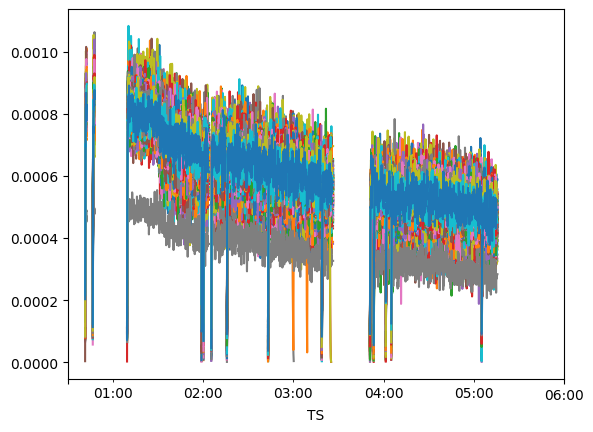

In [59]:
start_datetime = '2023-09-17 00:30:00'
end_datetime = '2023-09-17 06:00:00'

selected_rows = selected_columns.loc[start_datetime:end_datetime]
selected_rows[selected_rows>1e-6].plot(legend=False)

<Axes: xlabel='TS'>

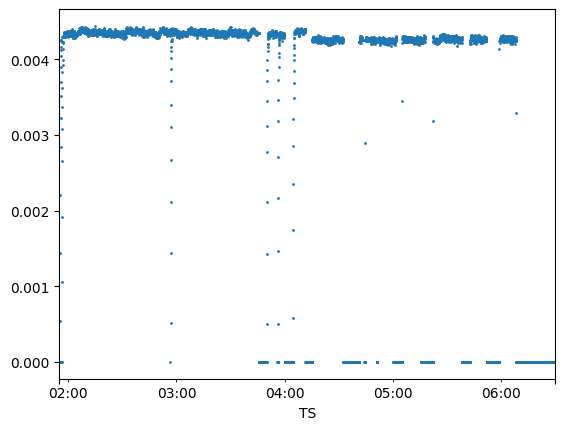

In [286]:
#Fill 9168
start_datetime = '2023-09-20 01:39:00'
end_datetime = '2023-09-20 06:30:00'

selected_rows = selected_columns.loc[start_datetime:end_datetime]
median_per_timestamp = selected_rows.median(axis=1)
median_per_timestamp.plot(marker='.',markersize=2,linestyle="None",label="median",)


In [203]:
cleaned_9168 = selected_rows[selected_rows>=0]

In [204]:
std_per_timestamp = cleaned_9168.std(axis=1)

# Identifica e rimuovi gli outliers (valori al di fuori di 5 deviazioni standard dal valore medio)
mean_per_timestamp = cleaned_9168.mean(axis=1)
threshold =  5*std_per_timestamp
outliers = (cleaned_9168.T - mean_per_timestamp).abs() > threshold
cleaned_df = cleaned_9168.T.mask(outliers)
# Calcola la deviazione standard dei dati "puliti" per ciascun intervallo di tempo
std_per_timestamp_cleaned = cleaned_df.std(axis=0)
mean_per_timestamp_cleaned = cleaned_df.mean(axis=0)

In [205]:
cleaned_9168_wo_outliers = cleaned_df.T

In [206]:
fill_9168_wo_0=cleaned_9168_wo_outliers.loc[:, (cleaned_9168_wo_outliers**2).sum() != 0]*64000/22

In [207]:
selected_rows_list = list(selected_rows.columns)
cleaned_9168_list = list(cleaned_9168_wo_outliers.columns)
fill_9168_wo_0_list = list(fill_9168_wo_0.columns)

In [212]:
cleaned_9168_wo_outliers.describe()

lumi_M00_0_outer  lumi_M00_1_outer  lumi_M01_0_outer  lumi_M01_1_outer  \
count       5821.000000       5821.000000            5821.0            5821.0   
mean           0.003253          0.003246               0.0               0.0   
std            0.002015          0.002014               0.0               0.0   
min            0.000000          0.000000               0.0               0.0   
25%            0.000000          0.000000               0.0               0.0   
50%            0.004454          0.004445               0.0               0.0   
75%            0.004553          0.004544               0.0               0.0   
max            0.004920          0.004895               0.0               0.0   

       lumi_M02_0_outer  lumi_M02_1_outer  lumi_M03_0_outer  lumi_M03_1_outer  \
count       5820.000000       5821.000000            5821.0            5821.0   
mean           0.003264          0.003200               0.0               0.0   
std            0.002023          0.001984               0.0               0.0   
min            0.000000          0.000000               0.0               0.0   
25%            0.000000          0.000000               0.0               0.0   
50%            0.004469          0.004377               0.0               0.0   
75%            0.004568          0.004482               0.0               0.0   
max            0.004894          0.004794               0.0               0.0   

       lumi_M04_0_outer  lumi_M04_1_outer  ...  lumi_M46_1_inner  \
count       5821.000000       5821.000000  ...       5820.000000   
mean           0.003266          0.003290  ...          0.003168   
std            0.002049          0.002037  ...          0.001961   
min            0.000000          0.000000  ...          0.000000   
25%            0.000000          0.000000  ...          0.000000   
50%            0.004499          0.004494  ...          0.004343   
75%            0.004601          0.004602  ...          0.004424   
max            0.004920          0.005037  ...          0.004742   

       lumi_M47_0_inner  lumi_M47_1_inner  lumi_M48_0_inner  lumi_M48_1_inner  \
count            5821.0            5821.0       5821.000000       5821.000000   
mean                0.0               0.0          0.003167          0.003165   
std                 0.0               0.0          0.001959          0.001959   
min                 0.0               0.0          0.000000          0.000000   
25%                 0.0               0.0          0.000000          0.000000   
50%                 0.0               0.0          0.004338          0.004337   
75%                 0.0               0.0          0.004424          0.004425   
max                 0.0               0.0          0.004763          0.004688   

       lumi_M49_0_inner  lumi_M49_1_inner  lumi_M50_0_inner  lumi_M51_0_inner  \
count            5821.0            5821.0       5819.000000            5821.0   
mean                0.0               0.0          0.003185               0.0   
std                 0.0               0.0          0.001970               0.0   
min                 0.0               0.0          0.000000               0.0   
25%                 0.0               0.0          0.000000               0.0   
50%                 0.0               0.0          0.004362               0.0   
75%                 0.0               0.0          0.004447               0.0   
max                 0.0               0.0          0.004753               0.0   

       lumi_M51_1_inner  
count            5821.0  
mean                0.0  
std                 0.0  
min                 0.0  
25%                 0.0  
50%                 0.0  
75%                 0.0  
max                 0.0  

[8 rows x 191 columns]

In [219]:
difference = list(set(selected_rows_list) - set(fill_9168_wo_0_list))
len(difference)

92

<Axes: xlabel='TS'>

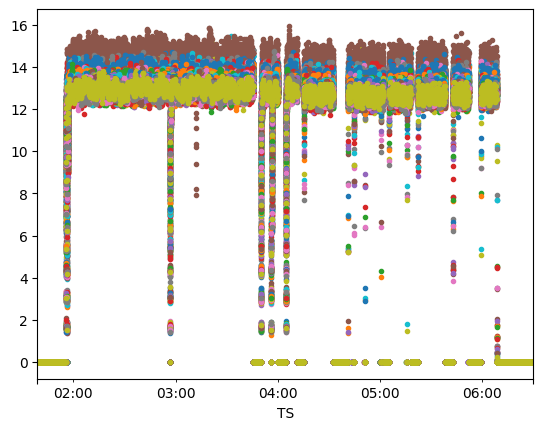

In [168]:
fill_9168_wo_0.plot(legend=False,linestyle='',marker='.')

In [190]:
std_per_timestamp_cleaned = fill_9168_wo_0.std(axis=1)
mean_per_timestamp_cleaned = fill_9168_wo_0.mean(axis=1)
median_per_timestamp_cleaned = fill_9168_wo_0.median(axis=1)
np_array = fill_9168_wo_0.T.to_numpy()
truncated_means = trim_mean(np_array, 0.3)
truncated_means_cleaned = pd.Series(truncated_means, index=median_per_timestamp_cleaned.index)

rel_std_cleaned = std_per_timestamp_cleaned/truncated_means_cleaned

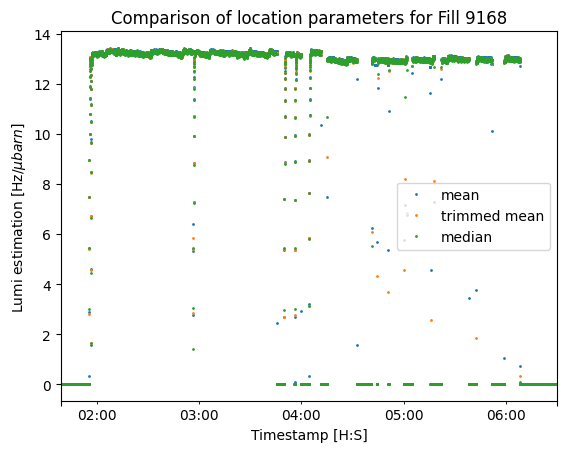

In [191]:
mean_per_timestamp_cleaned.plot(marker='.',markersize=2,linestyle="None",label="mean")
truncated_means_cleaned.plot(marker='.',markersize=2,linestyle="None",label="trimmed mean")
median_per_timestamp_cleaned.plot(marker='.',markersize=2,linestyle="None",label="median",)
plt.ylabel("Lumi estimation [Hz/$\mu barn$]")
plt.xlabel("Timestamp [H:S]")
plt.title("Comparison of location parameters for Fill 9168")
plt.legend()

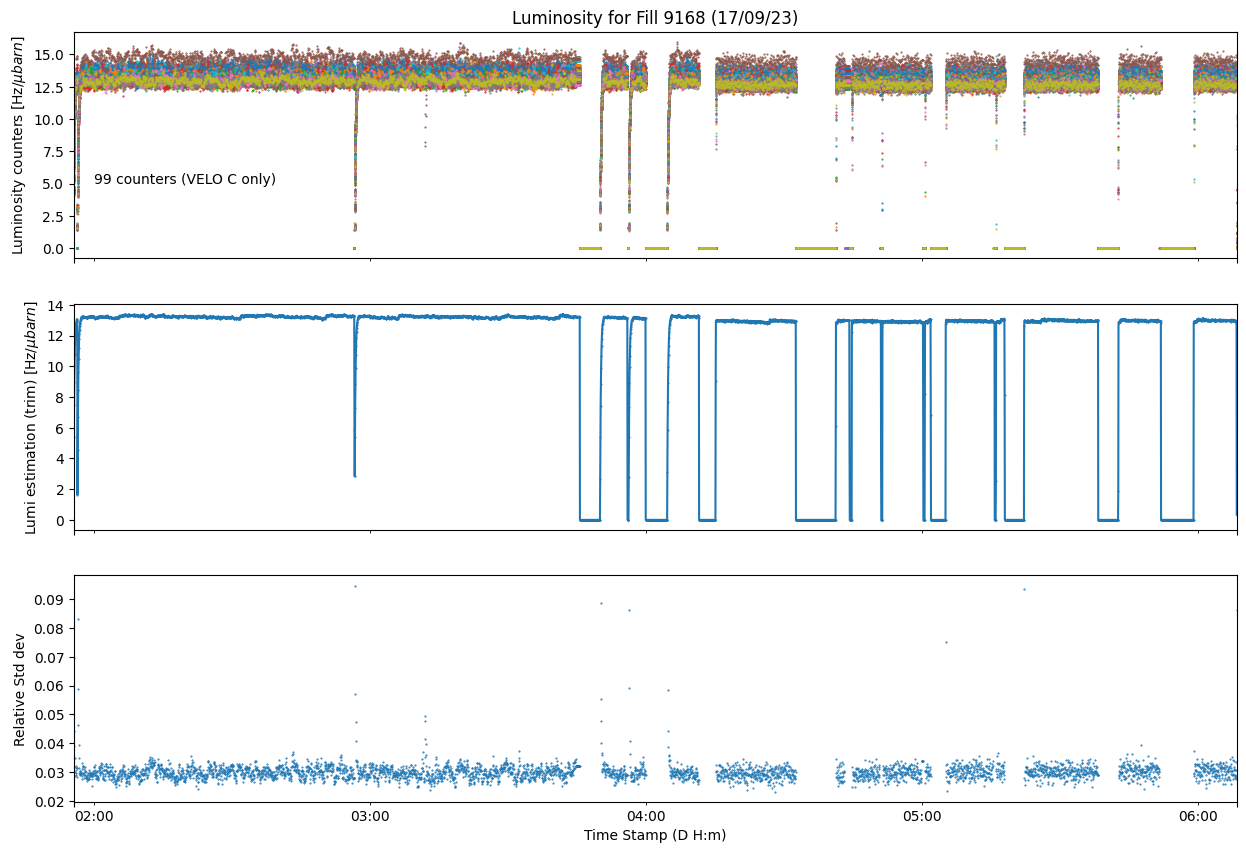

In [229]:
_, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 10))

ax0 = fill_9168_wo_0.plot(legend=False,
                          linestyle='',
                          marker='.',
                          markersize=1,
                          title="Luminosity for Fill 9168 (17/09/23)",
                          ylabel="Luminosity counters [Hz/$\mu barn$]",
                          ax=axes[0]
                         )

ax1 = truncated_means_cleaned.plot(
        marker=".",
        markersize=1,
        
        xlabel="Time Stamp (D H:m)",
        ylabel="Lumi estimation (trim) [Hz/$\mu barn$]",
        ax=axes[1],
    )


ax2 = rel_std_cleaned[rel_std_cleaned<0.1].plot(
    linestyle='',
    marker='.',
    markersize=1,
    xlabel="Time Stamp (D H:m)",
    ylabel="Relative Std dev",
    ax=axes[2],
)
ax0.text(dt.datetime(2023, 9, 20,2,0), 5, '99 counters (VELO C only)', fontsize = 10) 

plt.show()

In [222]:
len(fill_9168_wo_0.columns)

99

Text(0, 0.5, 'Counts')

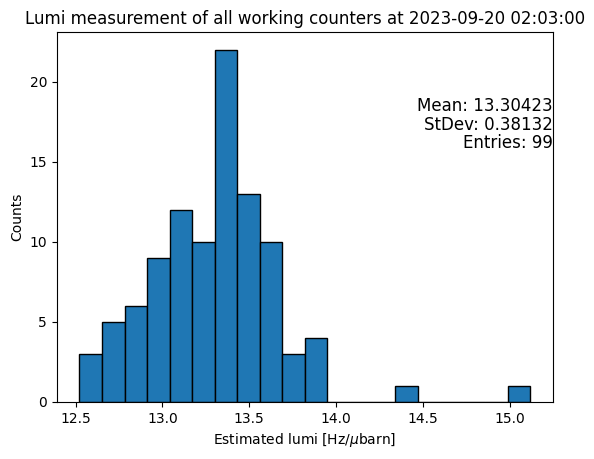

In [230]:
var='2023-09-20 02:03:00'
f, ax = plt.subplots()
plt.hist(fill_9168_wo_0.T[var], bins=20, edgecolor='k')

# Calcola le statistiche
mean_value = fill_9168_wo_0.T[var].mean()
std_deviation = fill_9168_wo_0.T[var].std()
min_value = fill_9168_wo_0.T[var].min()
max_value = fill_9168_wo_0.T[var].max()
num_entries = len(fill_9168_wo_0.T)

# Aggiungi le statistiche come testo sulla canvas dell'istogramma
plt.text(1., 0.8, f'Mean: {mean_value:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(1., 0.75, f'StDev: {std_deviation:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
#plt.text(.00045, 6, f'Min: {min_value:.2f}', fontsize=1, color='red')
#plt.text(.00045, 50, f'Max: {max_value:.2f}', fontsize=1, color='red')
plt.text(1., 0.7, f'Entries: {num_entries}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)

plt.title('Lumi measurement of all working counters at ' + var)
plt.xlabel('Estimated lumi [Hz/$\mu$barn]')
plt.ylabel('Counts')

#plt.show()


Text(0, 0.5, 'Counts')

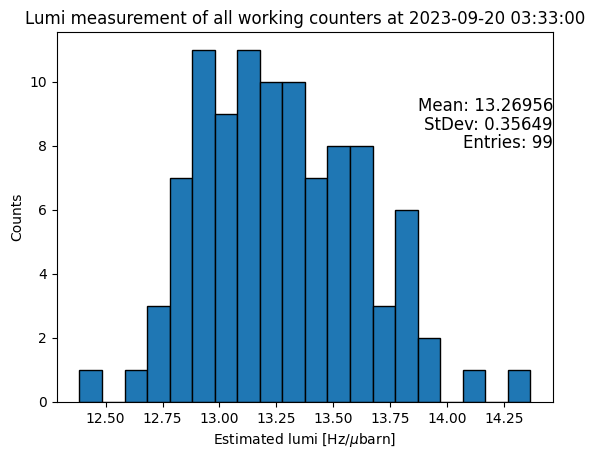

In [234]:
var='2023-09-20 03:33:00'
f, ax = plt.subplots()
plt.hist(fill_9168_wo_0.T[var], bins=20, edgecolor='k')

# Calcola le statistiche
mean_value = fill_9168_wo_0.T[var].mean()
std_deviation = fill_9168_wo_0.T[var].std()
min_value = fill_9168_wo_0.T[var].min()
max_value = fill_9168_wo_0.T[var].max()
num_entries = len(fill_9168_wo_0.T)

# Aggiungi le statistiche come testo sulla canvas dell'istogramma
plt.text(1., 0.8, f'Mean: {mean_value:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(1., 0.75, f'StDev: {std_deviation:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
#plt.text(.00045, 6, f'Min: {min_value:.2f}', fontsize=1, color='red')
#plt.text(.00045, 50, f'Max: {max_value:.2f}', fontsize=1, color='red')
plt.text(1., 0.7, f'Entries: {num_entries}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)

plt.title('Lumi measurement of all working counters at ' + var)
plt.xlabel('Estimated lumi [Hz/$\mu$barn]')
plt.ylabel('Counts')

#plt.show()


Text(0, 0.5, 'Counts')

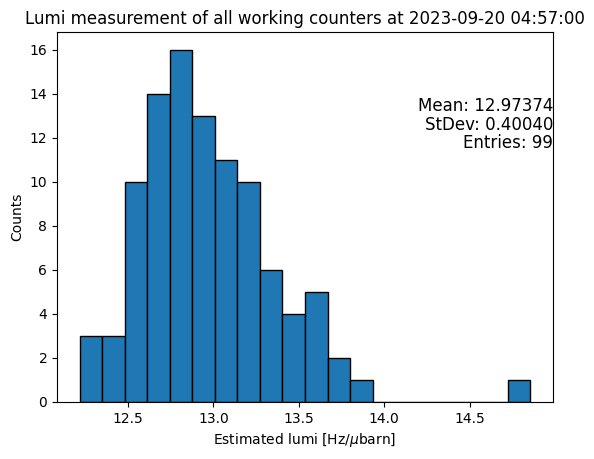

In [235]:
var='2023-09-20 04:57:00'
f, ax = plt.subplots()
plt.hist(fill_9168_wo_0.T[var], bins=20, edgecolor='k')

# Calcola le statistiche
mean_value = fill_9168_wo_0.T[var].mean()
std_deviation = fill_9168_wo_0.T[var].std()
min_value = fill_9168_wo_0.T[var].min()
max_value = fill_9168_wo_0.T[var].max()
num_entries = len(fill_9168_wo_0.T)

# Aggiungi le statistiche come testo sulla canvas dell'istogramma
plt.text(1., 0.8, f'Mean: {mean_value:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(1., 0.75, f'StDev: {std_deviation:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
#plt.text(.00045, 6, f'Min: {min_value:.2f}', fontsize=1, color='red')
#plt.text(.00045, 50, f'Max: {max_value:.2f}', fontsize=1, color='red')
plt.text(1., 0.7, f'Entries: {num_entries}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)

plt.title('Lumi measurement of all working counters at ' + var)
plt.xlabel('Estimated lumi [Hz/$\mu$barn]')
plt.ylabel('Counts')

#plt.show()


Text(0, 0.5, 'Counts')

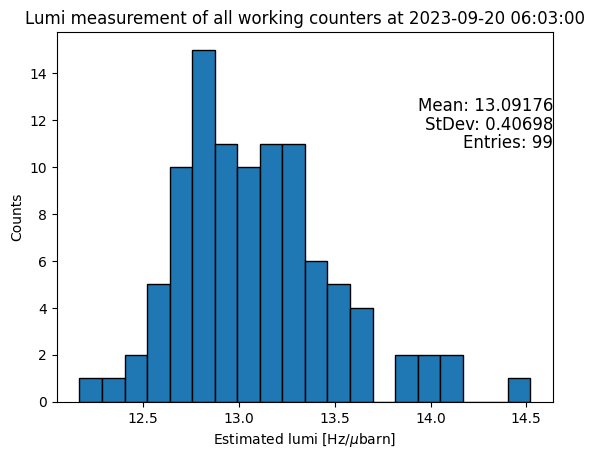

In [237]:
var='2023-09-20 06:03:00'
f, ax = plt.subplots()
plt.hist(fill_9168_wo_0.T[var], bins=20, edgecolor='k')

# Calcola le statistiche
mean_value = fill_9168_wo_0.T[var].mean()
std_deviation = fill_9168_wo_0.T[var].std()
min_value = fill_9168_wo_0.T[var].min()
max_value = fill_9168_wo_0.T[var].max()
num_entries = len(fill_9168_wo_0.T)

# Aggiungi le statistiche come testo sulla canvas dell'istogramma
plt.text(1., 0.8, f'Mean: {mean_value:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(1., 0.75, f'StDev: {std_deviation:.5f}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)
#plt.text(.00045, 6, f'Min: {min_value:.2f}', fontsize=1, color='red')
#plt.text(.00045, 50, f'Max: {max_value:.2f}', fontsize=1, color='red')
plt.text(1., 0.7, f'Entries: {num_entries}', fontsize=12, horizontalalignment='right',
     verticalalignment='center',
     transform = ax.transAxes)

plt.title('Lumi measurement of all working counters at ' + var)
plt.xlabel('Estimated lumi [Hz/$\mu$barn]')
plt.ylabel('Counts')

#plt.show()


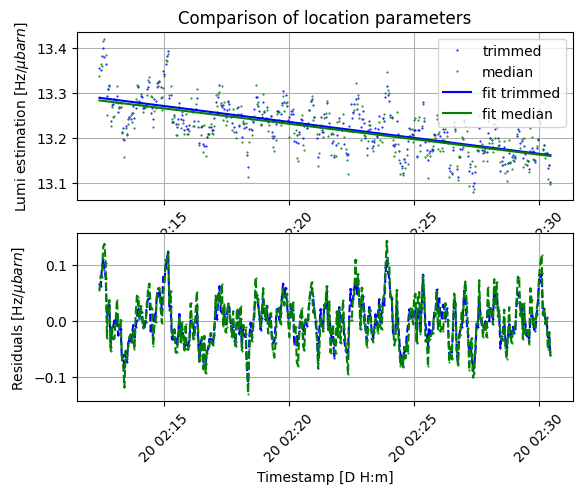

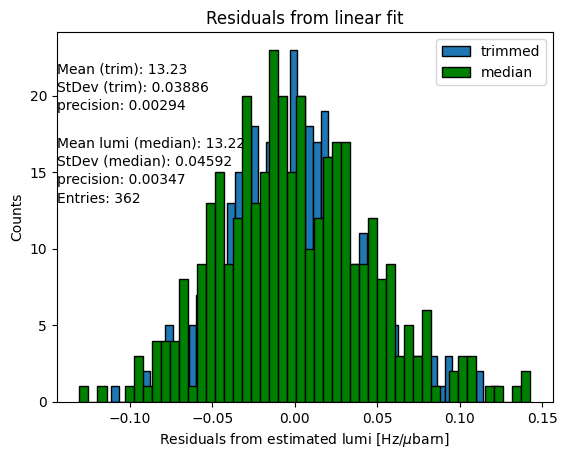

In [309]:
from scipy.optimize import curve_fit
import pylab
import matplotlib.dates as mdates

def funzionefit(x,m, q):
    return   x*m+q

y_median=median_per_timestamp_cleaned#[median_per_timestamp_cleaned>12.5]
y_median = y_median .between_time('02:12:22','02:30:27')
x_median=np.linspace(0, len(y_median), len(y_median))
x = mdates.date2num(list(y_median.index))
xx = np.linspace(x.min(), x.max(), len(x))
dd = mdates.num2date(xx)

init=(0.002, 0.)
pars_median, covm_median = curve_fit(funzionefit, x, y_median) 
m_median,q_median=pars_median

res_median=y_median - funzionefit(x, m_median,q_median)

y_trim=truncated_means_cleaned#[truncated_means_cleaned>12.5]
y_trim = y_trim.between_time('02:12:22','02:30:27')

x_trim=np.linspace(0, len(y_trim), len(y_trim))
x_trim = mdates.date2num(list(y_trim.index))
xx_trim = np.linspace(x_trim.min(), x_trim.max(), len(x_trim))
dd_trim = mdates.num2date(xx_trim)
init=(0.002, 0.)
pars_trim, covm_trim = curve_fit(funzionefit, x_trim, y_trim) 
m_trim,q_trim=pars_trim

res_trim=y_trim - funzionefit(x_trim, m_trim,q_trim)


##GRAFICO DEL FIT E DEI RESIDUI
plt.figure(1)
plt.subplot(211) #211 significa che divido il grafico in 2 righe e 1 colonna e posiziona il grafico che stiamo per fare per 1°
plt.plot(list(y_trim.index), y_trim, linestyle='', marker='.',markersize=1,label='trimmed',color='blue')
plt.plot(list(y_median.index), y_median, linestyle='', marker='.',markersize=1,label='median',color='green')
plt.ylabel("Lumi estimation [Hz/$\mu barn$]")
plt.title("Comparison of location parameters")
plt.grid()
xx = np.linspace(min(x_median), max(x_median), 100)
pylab.plot(dd_trim, funzionefit(x_trim, m_trim,q_trim), color='blue',label='fit trimmed')
pylab.plot(dd, funzionefit(x, m_median,q_median), color='green',label='fit median')
pylab.xticks(rotation=45)
pylab.legend()


plt.subplot(212)
plt.xlabel("Timestamp [D H:m]")
pylab.ylabel('Residuals [Hz/$\mu barn$]')
pylab.errorbar(list(y_trim.index), res_trim, None, None, linestyle='--', color='blue', marker='.',markersize=1)
pylab.errorbar(list(y_median.index), res_median, None, None, linestyle='--', color='green', marker='.',markersize=1)
pylab.grid()
pylab.xticks(rotation=45)
pylab.show()


f, ax = plt.subplots()
#bins = np.linspace(-0.025, 0.025, 100)
plt.hist(res_trim, edgecolor='k',label="trimmed",bins=50)
plt.hist(res_median, edgecolor='k',label="median",bins=50,color='green')

# Calcola le statistiche
mean_value = res_mean.mean()
std_deviation = res_mean.std()
num_entries = len(res_mean)

mean_value_trim = y_trim.mean()
std_deviation_trim = res_trim.std()
num_entries_trim = len(res_trim)
prec_trim = std_deviation_trim/mean_value_trim

mean_value_median = y_median.mean()
std_deviation_median = res_median.std()
num_entries_median = len(res_median)
prec_median = std_deviation_median/mean_value_median



# Aggiungi le statistiche come testo sulla canvas dell'istogramma
plt.text(0., 0.9, f'Mean (trim): {mean_value_trim:.2f}', fontsize=10, horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(0., 0.85, f'StDev (trim): {std_deviation_trim:.5f}', fontsize=10, horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(0., 0.8, f'precision: {prec_trim:.5f}', fontsize=10, horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
#plt.text(.00045, 6, f'Min: {min_value:.2f}', fontsize=1, color='red')
#plt.text(.00045, 50, f'Max: {max_value:.2f}', fontsize=1, color='red')


# Aggiungi le statistiche come testo sulla canvas dell'istogramma
plt.text(0., 0.7, f'Mean lumi (median): {mean_value_median:.2f}', fontsize=10, horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(0., 0.65, f'StDev (median): {std_deviation_median:.5f}', fontsize=10, horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
plt.text(0., 0.6, f'precision: {prec_median:.5f}', fontsize=10, horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)
#plt.text(.00045, 6, f'Min: {min_value:.2f}', fontsize=1, color='red')
#plt.text(.00045, 50, f'Max: {max_value:.2f}', fontsize=1, color='red')
plt.text(0., 0.55, f'Entries: {num_entries_median}', fontsize=10, horizontalalignment='left',
     verticalalignment='center',
     transform = ax.transAxes)

plt.title('Residuals from linear fit')
plt.xlabel('Residuals from estimated lumi [Hz/$\mu$barn]')
plt.ylabel('Counts')
plt.legend(loc="upper right")
#plt.show()


In [3]:
import yaml
import pandas as pd
import numpy as np

/var/folders/7t/860dclk54774ltwycrvfp7nc0000gn/T/ipykernel_25975/938478901.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
stream = open("../../../data_vdm_2022/output_data/sigma_vis_dani.yaml", "r", encoding="utf-8")
config_dictionary = yaml.safe_load(stream)

In [3]:
config_dictionary

{'sigma_vis_outer': {'M01_0': 0.000880225,
  'M03_0': 0.000900064,
  'M05_0': 0.000870938,
  'M07_0': 0.00084043,
  'M09_0': 0.000815541,
  'M11_0': 3.44734e-05,
  'M13_0': 0.000668149,
  'M15_0': 0.000643271,
  'M17_0': 0.00068526,
  'M19_0': 0.000718796,
  'M21_0': 0.000787395,
  'M23_0': 0.000828912,
  'M25_0': 5.74355e-06,
  'M27_0': 0.000786697,
  'M29_0': 0.000927465,
  'M31_0': 0.000931766,
  'M33_0': None,
  'M35_0': None,
  'M37_0': 0.000945395,
  'M39_0': 7.71888e-05,
  'M41_0': 6.77294e-05,
  'M43_0': None,
  'M45_0': None,
  'M47_0': 0.000878657,
  'M49_0': 0.00089458,
  'M51_0': 0.000429775,
  'M00_0': 0.000934549,
  'M02_0': 0.000924941,
  'M04_0': None,
  'M06_0': None,
  'M08_0': None,
  'M10_0': None,
  'M12_0': 0.000696084,
  'M14_0': 0.000659516,
  'M16_0': 0.000650447,
  'M18_0': 0.000693981,
  'M20_0': 0.000756246,
  'M22_0': 0.000822092,
  'M24_0': 0.000876991,
  'M26_0': 0.00090655,
  'M28_0': 0.000935972,
  'M30_0': 0.000952221,
  'M32_0': None,
  'M34_0': 0.000

In [4]:
config_dictionary["sigma_vis_outer"]

{'M01_0': 0.000880225,
 'M03_0': 0.000900064,
 'M05_0': 0.000870938,
 'M07_0': 0.00084043,
 'M09_0': 0.000815541,
 'M11_0': 3.44734e-05,
 'M13_0': 0.000668149,
 'M15_0': 0.000643271,
 'M17_0': 0.00068526,
 'M19_0': 0.000718796,
 'M21_0': 0.000787395,
 'M23_0': 0.000828912,
 'M25_0': 5.74355e-06,
 'M27_0': 0.000786697,
 'M29_0': 0.000927465,
 'M31_0': 0.000931766,
 'M33_0': None,
 'M35_0': None,
 'M37_0': 0.000945395,
 'M39_0': 7.71888e-05,
 'M41_0': 6.77294e-05,
 'M43_0': None,
 'M45_0': None,
 'M47_0': 0.000878657,
 'M49_0': 0.00089458,
 'M51_0': 0.000429775,
 'M00_0': 0.000934549,
 'M02_0': 0.000924941,
 'M04_0': None,
 'M06_0': None,
 'M08_0': None,
 'M10_0': None,
 'M12_0': 0.000696084,
 'M14_0': 0.000659516,
 'M16_0': 0.000650447,
 'M18_0': 0.000693981,
 'M20_0': 0.000756246,
 'M22_0': 0.000822092,
 'M24_0': 0.000876991,
 'M26_0': 0.00090655,
 'M28_0': 0.000935972,
 'M30_0': 0.000952221,
 'M32_0': None,
 'M34_0': 0.00096698,
 'M36_0': 0.000977337,
 'M38_0': 0.000966659,
 'M40_0': 

In [5]:
config_dictionary['sigma_vis_outer'] = {key + '_outer': value for key, value in config_dictionary['sigma_vis_outer'].items()}


In [7]:
config_dictionary['sigma_vis_inner'] = {key + '_inner': value for key, value in config_dictionary['sigma_vis_inner'].items()}


In [8]:
config_dictionary

{'sigma_vis_outer': {'M01_0_outer': 0.000880225,
  'M03_0_outer': 0.000900064,
  'M05_0_outer': 0.000870938,
  'M07_0_outer': 0.00084043,
  'M09_0_outer': 0.000815541,
  'M11_0_outer': 3.44734e-05,
  'M13_0_outer': 0.000668149,
  'M15_0_outer': 0.000643271,
  'M17_0_outer': 0.00068526,
  'M19_0_outer': 0.000718796,
  'M21_0_outer': 0.000787395,
  'M23_0_outer': 0.000828912,
  'M25_0_outer': 5.74355e-06,
  'M27_0_outer': 0.000786697,
  'M29_0_outer': 0.000927465,
  'M31_0_outer': 0.000931766,
  'M33_0_outer': None,
  'M35_0_outer': None,
  'M37_0_outer': 0.000945395,
  'M39_0_outer': 7.71888e-05,
  'M41_0_outer': 6.77294e-05,
  'M43_0_outer': None,
  'M45_0_outer': None,
  'M47_0_outer': 0.000878657,
  'M49_0_outer': 0.00089458,
  'M51_0_outer': 0.000429775,
  'M00_0_outer': 0.000934549,
  'M02_0_outer': 0.000924941,
  'M04_0_outer': None,
  'M06_0_outer': None,
  'M08_0_outer': None,
  'M10_0_outer': None,
  'M12_0_outer': 0.000696084,
  'M14_0_outer': 0.000659516,
  'M16_0_outer': 0.0

In [9]:
df_outer = pd.DataFrame(config_dictionary['sigma_vis_outer'], index=[0])
df_inner = pd.DataFrame(config_dictionary['sigma_vis_inner'], index=[0])

In [12]:
df_outer = df_outer.T
df_inner = df_inner.T

In [26]:
df_concatenated = pd.concat([df_outer, df_inner])


In [27]:
df_concatenated.reset_index(inplace=True)

In [28]:
df_concatenated.columns = ['colName','calibration']

In [30]:
df_concatenated.dropna()

colName calibration
0    M01_0_outer     0.00088
1    M03_0_outer      0.0009
2    M05_0_outer    0.000871
3    M07_0_outer     0.00084
4    M09_0_outer    0.000816
..           ...         ...
203  M42_1_inner    0.002419
204  M44_1_inner    0.002387
205  M46_1_inner    0.002403
206  M48_1_inner    0.002441
207  M50_1_inner    0.002441

[160 rows x 2 columns]

In [33]:
df_concatenated.to_csv("../../../data_vdm_2022/output_data/sigma_vis_dani.csv",index=False)

In [34]:
def plot_figure(df, mean, rel_std,year):
    _, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 10))

    ax0 = df.plot(legend=False,
                          linestyle='',
                          marker='.',
                          markersize=1,
                          title="Luminosity for Vdm"+year+" calibration",
                          ylabel="Lumi counters [Hz/$\mu barn$]",
                          ax=axes[0]
                         )

    ax1 = mean.plot(
        marker=".",
        markersize=1,
        
        xlabel="Time Stamp (D H:m)",
        ylabel="Lumi estimation (trim) [Hz/$\mu barn$]",
        ax=axes[1],
    )


    ax2 = rel_std[rel_std<0.1].plot(
    linestyle='',
    marker='.',
    markersize=1,
    xlabel="Time Stamp (D H:m)",
    ylabel="Relative Std dev",
    ax=axes[2],
    )

    plt.show()

In [4]:
stream = open("config.yaml", "r", encoding="utf-8")
config_dictionary = yaml.safe_load(stream)
#set options according to configuration file
display_fig = config_dictionary["displayFig"]
calib_year = config_dictionary["calib_year"]
folder_name = config_dictionary["folder_name"]
#get year of calibration from config file, search for data in the right folder
smog = config_dictionary["smog"]
if calib_year == "2023":
    str_year = "data_vdm_2023"
elif calib_year == "2022":
    str_year = "data_vdm_2022"
#get sigma vis from configuration file
#df_sigma_vis = pd.read_csv("../../../" + str_year + "/output_data/sigma_vis"+smog+".csv")
df_sigma_vis = pd.read_csv("../../../" + str_year + "/output_data/sigma_vis_dani.csv")
df_sigma_vis.set_index("colName",inplace=True)
df_sigma_vis.dropna(inplace=True)
#new_df = df_sigma_vis
#new_df = new_df[new_df["calibration"]>0]
#new_df = new_df[new_df["calibration"]<10]
#new_df = new_df[new_df["error_calibration"]<0.2]
#df_sigma_vis = new_df
calib_colname = list(df_sigma_vis.index)
#if the dataset is already created, load it
df_merged_unique = pd.read_csv(
        "../../../" + folder_name + "/input_data/data_merged.csv"
    )
df_merged_unique["TS"] = pd.to_datetime(
        df_merged_unique["TS"], format="%Y-%m-%d %H:%M:%S"
        )
df_merged_unique = df_merged_unique.set_index("TS")
mask = (df_merged_unique.index> config_dictionary["StartOfAnalysis"]) & (df_merged_unique.index <= config_dictionary["EndOfAnalysis"])
df_merged_unique = df_merged_unique.loc[mask]
#countertype = ["outer", "inner"]
var_list = [col for col in df_merged_unique.columns if col.startswith("M")]
list_to_loop = list(set(var_list) & set(calib_colname))

In [5]:
df_lumi = pd.DataFrame()
for el in list_to_loop:
    df_lumi['lumi_'+el] = df_merged_unique[el]*config_dictionary['nCollisions']*config_dictionary['lhc_frequency']/df_sigma_vis.loc[el]["calibration"]
    lumi_err_col_name = f"err_lumi_{el}"
df_only_lumi = df_lumi.filter(regex='^lumi_M')
cleaned_lumi = df_only_lumi[df_only_lumi>=0]
fill_wo_0=cleaned_lumi.loc[:, (cleaned_lumi**2).sum() != 0]*64/22

# Calcola i percentili 15 e 85 per ogni colonna
percentile_15 = fill_wo_0.T.quantile(0.1)
percentile_85 = fill_wo_0.T.quantile(0.9)
# Seleziona solo i valori compresi tra i percentili 15 e 85 per ogni colonna
df_trimmed = fill_wo_0.T.apply(lambda col: col[(col >= percentile_15[col.name]) & (col <= percentile_85[col.name])])
# Calcola la deviazione standard su questo nuovo set di dati
std_dev_trimmed = df_trimmed.std()
truncated_means = df_trimmed.mean()
#truncated_std = trimmed_std(np_array, 0.3)
truncated_means_cleaned = pd.Series(truncated_means, index=fill_wo_0.index)
#truncated_std_cleaned = pd.Series(truncated_std, index=median_per_timestamp_cleaned.index)
rel_std_cleaned = std_dev_trimmed/truncated_means_cleaned

/var/folders/7t/860dclk54774ltwycrvfp7nc0000gn/T/ipykernel_25975/2588490598.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lumi['lumi_'+el] = df_merged_unique[el]*config_dictionary['nCollisions']*config_dictionary['lhc_frequency']/df_sigma_vis.loc[el]["calibration"]
/var/folders/7t/860dclk54774ltwycrvfp7nc0000gn/T/ipykernel_25975/2588490598.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lumi['lumi_'+el] = df_merged_unique[el]*config_dictionary['nCollisions']*config_dictionary['lhc_frequency']/df_sigma_vis.loc[el]

In [88]:
truncated_means_cleaned.to_csv("../../../" + folder_name + "/output_data/trimmed_lumi.csv")


In [7]:
df_correct = df_trimmed.T

In [8]:
len(df_correct.columns)

160

In [9]:
df_correct.dropna(axis=1, how='all', inplace=True)

In [10]:
all_counters = config_dictionary["counters_name"]

In [11]:
all_counters_outer = ["lumi_"+counter + "_outer" for counter in all_counters]
all_counters_inner = ["lumi_"+counter + "_inner" for counter in all_counters]

In [12]:
all_counters = all_counters_outer + all_counters_inner

In [13]:
tmp = [counter[5:] for counter in all_counters if counter in df_correct.columns]
#all_counters = config_dictionary["counters_name"]
#all_counters_outer = [counter + "_outer" for counter in all_counters]
#all_counters_inner = [counter + "_inner" for counter in all_counters]
#all_counters = all_counters_outer + all_counters_inner
len(tmp)


160

In [14]:
tmp

['M00_0_outer',
 'M00_1_outer',
 'M01_0_outer',
 'M01_1_outer',
 'M02_0_outer',
 'M02_1_outer',
 'M03_0_outer',
 'M04_1_outer',
 'M05_0_outer',
 'M05_1_outer',
 'M07_0_outer',
 'M07_1_outer',
 'M09_0_outer',
 'M09_1_outer',
 'M11_0_outer',
 'M11_1_outer',
 'M12_0_outer',
 'M12_1_outer',
 'M13_0_outer',
 'M13_1_outer',
 'M14_0_outer',
 'M15_0_outer',
 'M16_0_outer',
 'M16_1_outer',
 'M17_0_outer',
 'M17_1_outer',
 'M18_0_outer',
 'M18_1_outer',
 'M19_0_outer',
 'M19_1_outer',
 'M20_0_outer',
 'M20_1_outer',
 'M21_0_outer',
 'M22_0_outer',
 'M22_1_outer',
 'M23_0_outer',
 'M23_1_outer',
 'M24_0_outer',
 'M25_0_outer',
 'M26_0_outer',
 'M26_1_outer',
 'M27_0_outer',
 'M27_1_outer',
 'M28_0_outer',
 'M28_1_outer',
 'M29_0_outer',
 'M30_0_outer',
 'M30_1_outer',
 'M31_0_outer',
 'M31_1_outer',
 'M32_1_outer',
 'M34_0_outer',
 'M34_1_outer',
 'M36_0_outer',
 'M37_0_outer',
 'M37_1_outer',
 'M38_0_outer',
 'M39_0_outer',
 'M40_0_outer',
 'M40_1_outer',
 'M41_0_outer',
 'M41_1_outer',
 'M42_0_

In [30]:
formatted_list = []
check_list = []
# Estraiamo gli indici dalla lista originale
indices = set(int(item[1:3]) for item in tmp)

# Ciclo sugli indici
for i in range(0,26):
    if(f"M{2*i:02d}_0_outer" in tmp):
        formatted_list.append(f"numclusterod{i}")
        check_list.append(f"M{2*i:02d}_0_outer")
    if(f"M{2*i:02d}_0_inner" in tmp):
        formatted_list.append(f"numclusterid{i}")
        check_list.append(f"M{2*i:02d}_0_inner")
    if(f"M{2*i:02d}_1_outer" in tmp):
        formatted_list.append(f"numclusterol{i}")
        check_list.append(f"M{2*i:02d}_1_outer")
    if(f"M{2*i:02d}_1_inner" in tmp): 
        formatted_list.append(f"numclusteril{i}")
        check_list.append(f"M{2*i:02d}_1_inner")
    if(f"M{2*i+1:02d}_0_outer" in tmp):
        formatted_list.append(f"numclusterou{i}")
        check_list.append(f"M{2*i+1:02d}_0_outer")
    if(f"M{2*i+1:02d}_0_inner" in tmp):
        formatted_list.append(f"numclusteriu{i}")
        check_list.append(f"M{2*i+1:02d}_0_inner")
    if(f"M{2*i+1:02d}_1_outer" in tmp):
        formatted_list.append(f"numclusteror{i}")
        check_list.append(f"M{2*i+1:02d}_1_outer")
    if(f"M{2*i+1:02d}_1_inner" in tmp):
        formatted_list.append(f"numclusterir{i}")
        check_list.append(f"M{2*i+1:02d}_1_inner")


formatted_output = '\n'.join(formatted_list)
print(formatted_list)

['numclusterod0', 'numclusterid0', 'numclusterol0', 'numclusteril0', 'numclusterou0', 'numclusteriu0', 'numclusteror0', 'numclusterir0', 'numclusterod1', 'numclusterid1', 'numclusterol1', 'numclusteril1', 'numclusterou1', 'numclusteriu1', 'numclusterir1', 'numclusterid2', 'numclusterol2', 'numclusterou2', 'numclusteriu2', 'numclusteror2', 'numclusterir2', 'numclusterid3', 'numclusterou3', 'numclusteriu3', 'numclusteror3', 'numclusterir3', 'numclusterou4', 'numclusteror4', 'numclusterir4', 'numclusterou5', 'numclusteriu5', 'numclusteror5', 'numclusterir5', 'numclusterod6', 'numclusterid6', 'numclusterol6', 'numclusteril6', 'numclusterou6', 'numclusteriu6', 'numclusteror6', 'numclusterir6', 'numclusterod7', 'numclusterid7', 'numclusteril7', 'numclusterou7', 'numclusteriu7', 'numclusterir7', 'numclusterod8', 'numclusterid8', 'numclusterol8', 'numclusteril8', 'numclusterou8', 'numclusteriu8', 'numclusteror8', 'numclusterir8', 'numclusterod9', 'numclusterid9', 'numclusterol9', 'numclusteril

In [33]:
set(check_list) == set(tmp)


True

In [31]:
len(formatted_list)

160

In [101]:
tmp

['M00_0_outer',
 'M00_1_outer',
 'M01_0_outer',
 'M01_1_outer',
 'M02_0_outer',
 'M02_1_outer',
 'M03_0_outer',
 'M04_1_outer',
 'M05_0_outer',
 'M05_1_outer',
 'M07_0_outer',
 'M07_1_outer',
 'M09_0_outer',
 'M09_1_outer',
 'M11_0_outer',
 'M11_1_outer',
 'M12_0_outer',
 'M12_1_outer',
 'M13_0_outer',
 'M13_1_outer',
 'M14_0_outer',
 'M15_0_outer',
 'M16_0_outer',
 'M16_1_outer',
 'M17_0_outer',
 'M17_1_outer',
 'M18_0_outer',
 'M18_1_outer',
 'M19_0_outer',
 'M19_1_outer',
 'M20_0_outer',
 'M20_1_outer',
 'M21_0_outer',
 'M22_0_outer',
 'M22_1_outer',
 'M23_0_outer',
 'M23_1_outer',
 'M24_0_outer',
 'M25_0_outer',
 'M26_0_outer',
 'M26_1_outer',
 'M27_0_outer',
 'M27_1_outer',
 'M28_0_outer',
 'M28_1_outer',
 'M29_0_outer',
 'M30_0_outer',
 'M30_1_outer',
 'M31_0_outer',
 'M31_1_outer',
 'M32_1_outer',
 'M34_0_outer',
 'M34_1_outer',
 'M36_0_outer',
 'M37_0_outer',
 'M37_1_outer',
 'M38_0_outer',
 'M39_0_outer',
 'M40_0_outer',
 'M40_1_outer',
 'M41_0_outer',
 'M41_1_outer',
 'M42_0_